# Introducción

En este cuaderno utilizamos la técnica de regularización de errores mediante descenso por coordenadas (*Coordinate Descent*). 

El descenso por coordenadas es una técnica de resolución de funciones de optimización basada en la búsqueda de mínimos a lo largo de planos de coordenadas.

En RAPIDS, esta técnica es usada para entrenar modelos de regresión, con un funcionamiento similar a otras técnicas de regresión provistas por el framework. En scikit-learn, es utilizado por métodos de regularización mediante caminos: *Elastic net path* y *Lasso path*.

# Sección 1: [Coordinate Descent mediante GPU](https://docs.rapids.ai/api/cuml/stable/api.html#coordinate-descent)

## Carga y tratamiento de datos

Importaciones
* **os** y **os.path**: importan utilidades de Python para tratamiento de ficheros y comprobación de rutas.
* **cudf**, **cupy** y **cuml**: librerías de RAPIDS.
* **pandas** y **numpy**: librerías de manejo de DataFrames y gestión numérica, de vectores y tablas. Equivalentes a cudf y cupy respectivamente para CPU.
* **sklearn**: librería de manejo de modelos machine learning, equivalente de cuml en CPU.

In [337]:
import os
import os.path

import cudf
import cupy as cp
import cuml
from cuml.metrics.regression import mean_squared_error as mnsq

import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import enet_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mnsq_cpu

Dibujo de gráficas (CPU)
* **itertools**: librería de Python para crear iterables eficientes.
* **matplotlib**: librería de dibujo de gráficas en Python. Debido a que no se encuentra por defecto en los entornos de instalación de RAPIDS, es necesario añadirla al entorno mediante conda u otro gestor de paquetes.

In [338]:
from itertools import cycle
import matplotlib.pyplot as plt

Ficheros de utilidades:
* **f_northing**: conversión de coordenadas latitud-longitud a norte-este, empleados en manejo de mapas y coordenadas.
* **f_northing_numpy**: equivalente de f_northing para estructuras de numpy.
* **f_price_range**: normalización de precios en rangos establecidos manualmente. Necesario para clasificación multiclase, no necesario para regresión (aunque representa una versión simplificada o normalizada del objetivo a resolver).
* **f_static_data**: funciones para cargar listas de datos estáticos, tales como nombres de ciudades a utilizar desde el directorio /data, columnas a leer por cada fichero CSV, y columnas a usar en el entrenamiento del modelo.
* **f_utils**: utilidades de conversión de datos a tipos float32/float64, limpiado de strings de precios, factorización de columnas complejas en mapas numéricos, etc.

In [339]:
%run ../utils/f_northing.py
%run ../utils/f_northing_numpy.py
%run ../utils/f_price_range.py
%run ../utils/f_static_data.py
%run ../utils/f_utils.py

Inicialización de datos:
* **cities_to_use**: lista de directorios dentro de /data sobre los que leer datasets en formato CSV. Cada directorio es una ciudad, área, estado o país.
* **columns_to_use**: lista de columnas a leer dentro de cada CSV. Todas las columnas deben existir y sus nombres deben coincidir.
* **columns_to_fit**: lista de columnas a utilizar para el entrenamiento de modelos de machine learning. Nos permite hacer múltiples usos de un dataset sin necesidad de leerlo de nuevo.

In [340]:
#cities_to_use = ['sevilla']
#cities_to_use = ['shanghai']
cities_to_use = cities_to_use_1()
#cities_to_use = cities_to_use_2()
columns_to_use = columns_to_use()
columns_to_fit = columns_to_fit()

El atributo **set_global_output_type** de cuml determina la salida de datos de las funciones de cuml. La opción 'cudf' devuelve tipos de datos que cumplen con la especificación de RAPIDS: cudf.DataFrame y Series.

Otros posibles valores (v0.18) son 'input' para mantener el formato de entrada, 'cupy' y 'numpy' para usar los formatos de las librerías correspondientes.

In [341]:
cuml.set_global_output_type('cudf')

El DataFrame **listings** representa el conjunto de datos final sobre el que realizar operaciones de ciencia de datos o machine learning. Por cada directorio de datos, leemos todos los ficheros CSV disponibles y los agregamos a **listings**.
* **standard_object_type**: algunas columnas no tienen un formato único de datos; esto puede deberse a diferentes departamentos o metodologías empleadas durante los varios *scraping* de datos de la fuente. Esta función convierte columnas (detectadas manualmente a priori) en tipo genérico *object*, que después convertiremos a un tipo de datos más apropiado para nuestro uso.
* **drop_duplicates**: dado que utilizamos múltiples *datasets* por ciudades, hay listados de AirBnB que no cambian durante varios meses. En este caso, no necesitamos datos redundantes, y los removemos del DataFrame final.
* **reset_index**: los datos de cada fichero se han unido mediante un DataFrame diferente, y por lo tanto los índices del DataFrame quedan mezclados al final del proceso. Con esta instrucción forzamos el índice de **listings** a ordenarse. La instrución añade una columna adicional con el índice antiguo, que podemos obviar con el parámetro drop=**True**.
* **shape**: instrucción que devuelve el tamaño completo del DataFrame en formato (filas, columnas)

In [342]:
listings = cudf.DataFrame()

for city in cities_to_use:
    directory = '../data/' + city + '/'
    if os.path.exists(directory):
        for file in os.listdir(directory):
            if file.endswith('.csv'):
                temp_df = cudf.read_csv(directory + file, usecols = columns_to_use)
                standard_object_type(temp_df, ['host_acceptance_rate', 'neighbourhood_cleansed'])
                if(temp_df['host_total_listings_count'].dtype != 'float64'):
                    temp_df['host_total_listings_count'] = temp_df['host_total_listings_count'].fillna(-1).astype('float64')
                if(temp_df['bathrooms'].dtype != 'float64'):
                    temp_df['bathrooms'] = temp_df['bathrooms'].fillna(-1).astype('float64')
                if(temp_df['bedrooms'].dtype != 'float64'):
                    temp_df['bedrooms'] = temp_df['bedrooms'].fillna(-1).astype('float64')
                if(temp_df['beds'].dtype != 'float64'):
                    temp_df['beds'] = temp_df['beds'].fillna(-1).astype('float64')
                if listings.size == 0:
                    listings = temp_df
                else:
                    for column in listings.columns:
                        if listings[column].dtype != temp_df[column].dtype:
                            print('Found error: '+column+' type '+listings[column].dtype.name+' doesnt match '+temp_df[column].dtype.name)
                    listings = listings.append(temp_df)
                    
listings = listings.drop_duplicates()
listings = listings.reset_index(drop=True)

Tratamiento simple:
* **type_conversion**: convertimos todas las columnas a un tipo de datos común: *float32* y *float64* son los más aceptados por los algoritmos de RAPIDS.
* **column_factorize**: dado que algunos algoritmos no suportan datos no numéricos, factorizamos las columnas de texto. La operación factorize() convierte una columna con valores no numéricos a un mapa en el que cada valor único se representa por un integer. En nuestro caso, no necesitaremos el mapa que reconoce cada valor, pero es posible usarlo para devolver formato a los datos de cara a estudio o representación.

Utilizamos versiones de tipo float64 para guardar el mayor grado posible de precisión sobre los valores numéricos, lo cual es deseable en  modelos de regresión.

In [343]:
type_conversion_64(listings, ['host_id', 'accommodates', 'number_of_reviews', 'reviews_per_month', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_90', 'availability_365', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds'])
column_factorize_64(listings, ['neighbourhood_cleansed', 'host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'instant_bookable'])

Tratamiento de cadenas:
* **clean_format_strings**: eliminamos el carácter '%' de campos que lo contienen, y convertimos el valor resultante a *float32*.
* **clean_format_price**: similar a la función anterior, pero eliminando caracteres de moneda (en nuestro caso, '$' y la coma de cantidades numéricas).
* **applyMap**: aplica una función sucesivamente a todos los valores de la columna indicada. Utilizaremos la función **priceRange** para normalizar los precios en rangos, a fin de simplificar el ejemplo. Esta normalización permite que el *dataset* pueda usarse para clasificación multiclase y regresión (con un margen potencial de error mayor que si empleamos los valores de precio originales).

In [344]:
clean_format_strings_64(listings, ['host_response_rate', 'host_acceptance_rate'])
clean_format_price_64(listings, ['price'])
listings['price'] = listings['price'].applymap(priceRange, 'float64')

A fin de visualizar los datos en un formato 2D similar a un mapa, convertimos las coordatas latitud-longitud en distancias norte-este, y les asignamos columnas nuevas.

El código necesario para visualizar datos se encuentra en el fichero *nb1_visual.ipynb*, Sección 3.

In [345]:
cupy_lat = cp.asarray(listings['latitude'])
cupy_long = cp.asarray(listings['longitude'])
n_cupy_array, e_cupy_array = latlong2osgbgrid_cupy(cupy_lat, cupy_long)
listings['northing'] = cudf.Series(n_cupy_array).astype('float64')
listings['easting'] = cudf.Series(e_cupy_array).astype('float64')

Visualización de las primeras 5 filas, para verificar el tratamiento de datos.

In [346]:
listings.head()

,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,northing,easting
0,23.0,-1.0,-1.0,-1.0,0.0,2.0,1.0,1.0,31.0,30.17865,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,0.16,6.796325e+06,-1.062058e+07
1,23.0,-1.0,-1.0,-1.0,0.0,2.0,1.0,1.0,31.0,30.17865,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,0.16,6.796325e+06,-1.062058e+07
2,23.0,-1.0,-1.0,-1.0,0.0,2.0,1.0,1.0,31.0,30.17865,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,0.15,6.796325e+06,-1.062058e+07
3,23.0,-1.0,-1.0,-1.0,0.0,2.0,1.0,1.0,31.0,30.17926,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,0.26,6.796218e+06,-1.062028e+07
4,23.0,-1.0,-1.0,-1.0,0.0,2.0,1.0,1.0,31.0,30.17989,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.00,6.796309e+06,-1.062006e+07


## Aplicación del algoritmo Coordinate Descent de RAPIDS

El algoritmo Coordinate Descent localiza mínimos en funciones a optimizar, mediante el descenso por direcciones determinadas por coordenadas dadas por el dataset.

Parámetros:
* **alpha**: grado de regularización del descenso. 0 es equivalente a [mínimos cuadrados ordinarios (MCO)](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados_ordinarios), que es el solucionador empleado por una regresión linear simple.

Funciones:
* **train_test_split**: funcion que toma un conjunto de datos y los separa en datos de entrenamiento y datos de prueba. Esto nos permite realizar predicciónes sin separar previamente los datos. El parámetro **train_size** indica qué porcentaje debería dedicarse a entrenamiento, en nuestro caso 0.9 = 90%.
* **fit**: aplica la función de regularización al modelo *(X,y)* indicado. El modelo resultante puede ser reutilizado para predecir valores múltiples veces.
* **predict**: aplica el modelo entrenado sobre un conjunto *X* de test.

In [347]:
%%time
model = cuml.CD(alpha=0.5)
X = listings[columns_to_fit]
y = listings['price']
x_train, x_test, y_train, y_test  = cuml.train_test_split(X, y, train_size=0.9)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

CPU times: user 922 ms, sys: 7.26 ms, total: 929 ms
Wall time: 926 ms


Debido a que los resultados de **predict** generan un nuevo DataFrame con índices ordenados, y el resultado de **train_test_split** mantiene los índices originales, es necesario resetearlos para mostrarlos en un sólo DataFrame. Este paso es opcional si se desea ver los resultados de las predicciones y los valores reales por separado.

In [348]:
y_test = y_test.reset_index(drop=True)

Mostramos los resultados de **predict** sobre el modelo entrenado junto a los valores *y* de test reales.

In [349]:
testdf = cudf.DataFrame()
testdf['pred'] = predictions.astype('float64')
testdf['real'] = y_test.astype('float64')
testdf.head()

,pred,real
0,1.850092,1.0
1,2.822269,4.0
2,4.654717,10.0
3,2.031501,0.0
4,2.683306,1.0


* **describe**: muestra estadísticas básicas sobre las columnas de un DataFrame, tales como mínimo y máximo, desviación estándar y percentiles 25%, 50%, etc.

In [350]:
testdf.describe(include='all')

,pred,real
count,145744.000000,145744.000000
mean,4.096868,4.134585
std,1.695581,3.445798
min,-12.375675,0.000000
25%,2.914056,2.000000
50%,3.938139,3.000000
75%,5.096219,6.000000
max,44.856992,11.000000


* **mean_squared_error (mnsq)**: calcula el error cuadrático medio sobre los valores de las columnas indicadas. Podemos ver así el error total de las predicciones.

In [351]:
loss = mnsq(testdf['real'], testdf['pred'])
print(loss)

8.580443548691676


# Sección 2: [regresión por coordenadas mediante CPU](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.enet_path.html#sklearn.linear_model.enet_path)

## Carga y tratamiento de datos

La lectura y tratamiento de los datos iniciales sigue el mismo proceso que para GPU:
1. Creamos un nuevo DataFrame vacío.
2. Recorremos los directorios disponibles.
3. Agregamos los CSV, convirtiendo columnas dispares a tipo *object* si fuera necesario.
4. Eliminamos duplicados.
5. Reordenamos el índice.

In [352]:
listings_cpu = pd.DataFrame()

for city in cities_to_use:
    directory = '../data/' + city + '/'
    if os.path.exists(directory):
        for file in os.listdir(directory):
            if file.endswith('.csv'):
                temp_df_cpu = pd.read_csv(directory + file, usecols = columns_to_use)
                standard_object_type(temp_df_cpu, ['host_acceptance_rate', 'neighbourhood_cleansed'])
                if(temp_df_cpu['host_total_listings_count'].dtype != 'float64'):
                    temp_df_cpu['host_total_listings_count'] = temp_df_cpu['host_total_listings_count'].fillna("-1").astype('float64')
                if(temp_df_cpu['bathrooms'].dtype != 'float64'):
                    temp_df_cpu['bathrooms'] = temp_df_cpu['bathrooms'].fillna("-1").astype('float64')
                if(temp_df_cpu['bedrooms'].dtype != 'float64'):
                    temp_df_cpu['bedrooms'] = temp_df_cpu['bedrooms'].fillna("-1").astype('float64')
                if(temp_df_cpu['beds'].dtype != 'float64'):
                    temp_df_cpu['beds'] = temp_df_cpu['beds'].fillna("-1").astype('float64')
                if listings_cpu.size == 0:
                    listings_cpu = temp_df_cpu
                else:
                    for column in listings_cpu.columns:
                        if listings_cpu[column].dtype != temp_df_cpu[column].dtype:
                            print('Found error: '+column+' type '+listings_cpu[column].dtype.name+' doesnt match '+temp_df_cpu[column].dtype.name)
                    listings_cpu = listings_cpu.append(temp_df_cpu)
                    
listings_cpu = listings_cpu.drop_duplicates()
listings_cpu = listings_cpu.reset_index(drop=True)

Las funciones **type_conversion**, **column_factorize**, **clean_format_strings** y **priceRange** son las mismas empleadas para GPU, ya que las operaciones subyacentes tienen la misma semántica y uso para cuDF/cupy como para pandas/numpy.

* **clean_format_price_cpu**: versión específica del tratado de cadenas de precios para CPU. Es necesario cambiar ligeramente el órden y número de operaciones para que numpy pueda ejecutar el mismo reemplazo de cadenas de precios que en GPU.

In [353]:
type_conversion_64(listings_cpu, ['host_id', 'accommodates', 'number_of_reviews', 'reviews_per_month', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_90', 'availability_365', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds'])
column_factorize_64(listings_cpu, ['neighbourhood_cleansed', 'host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'instant_bookable'])

clean_format_strings_64(listings_cpu, ['host_response_rate', 'host_acceptance_rate'])
clean_format_price_64_cpu(listings_cpu, ['price'])
listings_cpu['price'] = listings_cpu['price'].apply(priceRange, 'float64')

La única diferencia en la conversión de coordenadas latitud-logitud a norte-este es que utilizamos funciones aritméticas provistas por numpy en lugar de cupy.

In [354]:
numpy_lat = listings_cpu['latitude'].to_numpy()
numpy_long = listings_cpu['longitude'].to_numpy()
n_numpy_array, e_numpy_array = latlong2osgbgrid_numpy(numpy_lat, numpy_long)
listings_cpu['northing'] = pd.Series(n_numpy_array).astype('float64')
listings_cpu['easting'] = pd.Series(e_numpy_array).astype('float64')

In [355]:
listings_cpu.head()

,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,northing,easting
0,3159.0,0.0,100.0,100.0,0.0,1.0,0.0,0.0,0.0,52.36575,...,10.0,10.0,10.0,10.0,9.0,10.0,0.0,2.05,296936.511643,872297.846080
1,32366.0,0.0,100.0,100.0,0.0,2.0,0.0,1.0,1.0,52.37802,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.45,297980.560905,868856.643198
2,59484.0,0.0,100.0,97.0,1.0,2.0,0.0,0.0,2.0,52.36509,...,10.0,10.0,10.0,10.0,10.0,9.0,0.0,2.74,296550.626970,869051.152298
3,56142.0,-1.0,-1.0,53.0,0.0,2.0,0.0,0.0,1.0,52.37297,...,10.0,10.0,10.0,10.0,10.0,10.0,1.0,0.18,297359.422896,868277.747731
4,97647.0,1.0,100.0,100.0,0.0,1.0,0.0,1.0,1.0,52.38761,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,2.14,299039.842167,868699.005281


## Aplicación de algoritmo de búsqueda Elastic Net

*ElasticNet* es un modelo de regresión linear entrenado con regularización de error *l1* y *l2* simultáneamente, combinando características de otros modelos tales como *Lasso regression* y *Ridge regression*.
* **eps**: tamaño del camino a calcular.
* **l1_ratio**: peso del coeficiente de regularización *l1* con respecto a *l2*. Un valor de 1 significa que el modelo emplea la misma técnica que *Lasso regression*.
* **fit_intercept**: atributo derivado de *sklearn.LinearRegression*, nos permite calcular un valor de intercepción si fueran necesario (si los valores no están centrados).

In [356]:
%%time
x_train, x_test, y_train, y_test  = train_test_split(listings_cpu[columns_to_fit], listings_cpu['price'], train_size=0.9)
x_test_index = x_test.reset_index(drop=True)
y_test_index = y_test.reset_index(drop=True)
alphas_enet, coefs_enet, _ = enet_path(x_train, y_train, eps=5e-3, l1_ratio=0.5, fit_intercept=True)

CPU times: user 800 ms, sys: 221 ms, total: 1.02 s
Wall time: 632 ms


Visualización de los puntos sobre los que se ha calculado el modelo.

In [357]:
alphas_enet

array([2042.87484543, 1936.4176551 , 1835.50810437, 1739.85709763,
       1649.19060448, 1563.24887464, 1481.78569379, 1404.56767822,
       1331.37360616, 1261.99378404, 1196.22944574, 1133.8921831 ,
       1074.80340621, 1018.79383175,  965.70299797,  915.37880504,
        867.67707926,  822.46116005,  779.6015084 ,  738.97533576,
        700.46625227,  663.96393335,  629.36380355,  596.56673702,
        565.4787735 ,  536.01084914,  508.07854134,  481.60182687,
        456.50485265,  432.71571838,  410.16627063,  388.79190752,
        368.53139367,  349.32668478,  331.12276129,  313.86747084,
        297.51137876,  282.00762651,  267.31179743,  253.38178945,
        240.17769452,  227.66168426,  215.79790156,  204.55235789,
        193.89283592,  183.7887972 ,  174.21129469,  165.13288982,
        156.52757387,  148.3706935 ,  140.63888008,  133.30998274,
        126.36300493,  119.77804428,  113.53623555,  107.61969658,
        102.01147709,   96.6955101 ,   91.65656592,   86.88020

Visualización de los coeficientes resultantes.

In [358]:
coefs_enet

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 3.86756724e-18,  5.66617525e-04,  1.10430089e-03, ...,
         3.94459995e-03,  3.91239623e-03,  3.88249893e-03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Usando matplotlib e itertools de Python, creamos un gráfico en el cual podemos ver el [resultado de computar el elastic path mediante descenso por coordenadas.](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net)

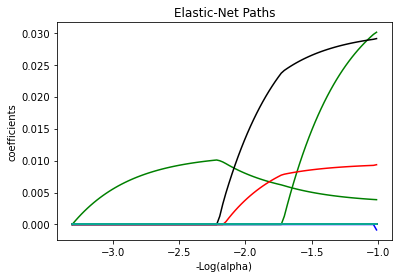

In [359]:
plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net Paths')
plt.axis('tight')
plt.show()

In [360]:
%reset -f